In [3]:
import os
import cv2
import glob
import pickle
import numpy as np
from tqdm import tqdm
from keras.utils import normalize
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from matplotlib.patches import Rectangle
from sklearn.metrics import average_precision_score

SIZE_X = 128
SIZE_Y = 128
n_channels = 3
n_classes = 10
Batch_size = 8
EPOCHS = 100
MODEL = 'unet'
BACKBONE = 'efficientnetb7'
encoder_weights = 'imagenet'
activation = 'softmax'
parent_directory = r'E:\Segmentation\datasets\FloodNet-Supervised_v1.0'

In [4]:
def load_images(parent_directory, split='train'):
    images = []
    masks = [] 

    image_folder_path = f'{parent_directory}\{split}\{split}-org-img'
    for img_path in tqdm(glob.glob(os.path.join(image_folder_path, "*.jpg"))):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        images.append(img)

        mask_path = (img_path.replace('org', 'label')).replace('jpg', 'png')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        masks.append(mask)
                
    images = np.array(images)
    masks = np.array(masks)

    print(f'{split.upper()}: Images loaded: {images.shape[0]}')
    print(f'{split.upper()}: Masks loaded: {masks.shape[0]}')

    return images, masks

In [5]:
def preprocess_data(images, masks, unet_preporcessing=None):
    if unet_preporcessing:
        images = unet_preporcessing(images)
    else:
        images = normalize(images, axis=1)
        
    masks = np.expand_dims(masks, axis=-1)
    masks = to_categorical(masks, num_classes=n_classes)
    masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], n_classes))

    return images, masks

In [6]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}
    
color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128], 
                 'Water': [0, 191, 255], 'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

handles = [Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()]

labels = [n for n,c in color_map.items()]


def to_RGB(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """    
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    for key, val in class_map.items():
      label_seg [np.all(label == class_map[key],axis=-1)] = color_map[key]  
    return label_seg

def display_images_with_masks(image, mask, predicted):
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Testing Label')
    plt.imshow(to_RGB(np.tile(np.expand_dims(mask, axis=-1), (1, 1, 3)))) 
    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(to_RGB(np.tile(np.expand_dims(predicted, axis=-1), (1, 1, 3))))
    plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
    plt.show()

In [ ]:
#Load the images
train_images, train_masks = load_images(parent_directory, split='train')
val_images, val_masks = load_images(parent_directory, split='val')

In [ ]:
data_to_save = {
    'train_images': train_images,
    'train_masks': train_masks,
    'val_images': val_images,
    'val_masks': val_masks
}

pickle_file_path = 'dataset/train_and_val_data.pickle'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)

print(f'Data saved to {pickle_file_path}')

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

In [7]:
pickle_file_path = '../../../dataset/train_and_val_data.pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

train_images = loaded_data['train_images']
train_masks = loaded_data['train_masks']
val_images = loaded_data['val_images']
val_masks = loaded_data['val_masks']

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Shapes of loaded data:
Train Images: (1445, 128, 128, 3)
Train Masks: (1445, 128, 128)
Val Images: (450, 128, 128, 3)
Val Masks: (450, 128, 128)


In [8]:
train_images, train_masks = preprocess_data(train_images, train_masks)
val_images, val_masks = preprocess_data(val_images, val_masks)

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Shapes of loaded data:
Train Images: (1445, 128, 128, 3)
Train Masks: (1445, 128, 128, 10)
Val Images: (450, 128, 128, 3)
Val Masks: (450, 128, 128, 10)


In [49]:
import segmentation_models as sm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Softmax
from tensorflow.keras.layers import concatenate, BatchNormalization, UpSampling2D, Activation, Conv2DTranspose

def res_inception_unit(input_layer, filters):
    # First convolutional block
    conv1x1_1 = Conv2D(filters, (1, 1), padding='same')(input_layer)
    conv1x1_1 = BatchNormalization()(conv1x1_1)

    # Second convolutional block
    conv1x1_2 = Conv2D(filters, (1, 1), padding='same')(input_layer)
    conv3x3_2 = Conv2D(filters, (3, 3), padding='same')(conv1x1_2)
    conv3x3_2 = BatchNormalization()(conv3x3_2)

    # Third convolutional block
    conv1x1_3 = Conv2D(filters, (1, 1), padding='same')(input_layer)
    conv3x3_3 = Conv2D(filters, (3, 3), padding='same')(conv1x1_3)
    conv3x3_3 = BatchNormalization()(conv3x3_3)
    conv3x3_3 = Conv2D(filters, (3, 3), padding='same')(conv3x3_3)
    conv3x3_3 = BatchNormalization()(conv3x3_3)

    concatenated = concatenate([conv1x1_1, conv3x3_2, conv3x3_3], axis=-1)

    output = Conv2D(filters, (1, 1), padding='same')(concatenated)
    output = Activation('relu')(output)
    return output

def pyramid_pooling_module(input_layer, levels=[1, 2, 4, 8]):
    pooled_outputs = []
    for level in levels:
        pooled = MaxPooling2D(pool_size=(level, level))(input_layer)
        pooled = Conv2D(filters=input_layer.shape[-1], kernel_size=(1, 1), padding='same', activation='relu')(pooled)
        pooled_outputs.append(pooled)
    upsampled_outputs = [UpSampling2D(size=(level, level))(pooled) for level, pooled in zip(levels, pooled_outputs)]
    concatenated = Concatenate(axis=-1)([input_layer] + upsampled_outputs)
    return concatenated

def dense_upsampling_convolution(input_layer, filters):
    x = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='same')(input_layer)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    return x

def encoder(inputs, encoder_filters):
    encoder_outputs = [inputs]
    for i, filters in enumerate(encoder_filters):
        x = res_inception_unit(encoder_outputs[-1], filters)
        encoder_outputs.append(MaxPooling2D(pool_size=(2, 2))(x) if i < len(encoder_filters) - 1 else x)
    return encoder_outputs

def decoder(global_feature_map, encoder_outputs, decoder_filters):
    x = global_feature_map
    for i, filters in enumerate(decoder_filters):
        x = dense_upsampling_convolution(x, filters)
        encoder_output = encoder_outputs[-(i + 2)]

        if encoder_output.shape[1:3] != x.shape[1:3]:
            encoder_output = Conv2D(filters, kernel_size=(1, 1), padding='same')(encoder_output)
            encoder_output = UpSampling2D(size=(2, 2))(encoder_output)
        x = concatenate([x, encoder_output], axis=-1)
        x = res_inception_unit(x, filters)
    return x

def build_model(input_shape, num_classes):
    inputs = Input(input_shape)
    encoder_filters = [32, 64, 128, 256, 512]

    encoder_outputs = encoder(inputs, encoder_filters)
    
    bridge_output = pyramid_pooling_module(encoder_outputs[-1], levels=[1, 2, 4, 8])

    decoder_filters = [512, 256, 128, 64]
    segmentation_map = decoder(bridge_output, encoder_outputs, decoder_filters)

    segmentation_map = Conv2D(num_classes, kernel_size=(1, 1), padding='same')(segmentation_map)
    segmentation_map = Softmax()(segmentation_map)

    model = Model(inputs, segmentation_map)
    return model

In [50]:
import tensorflow as tf

input_shape = (SIZE_X, SIZE_Y, n_channels)
model = build_model(input_shape, n_classes)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
hybrid_loss = dice_loss + (1 * focal_loss)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=optimizer, loss=hybrid_loss, metrics=[sm.metrics.iou_score])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_853 (Conv2D)            (None, 128, 128, 32  128         ['input_18[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_854 (Conv2D)            (None, 128, 128, 32  9248        ['conv2d_853[0][0]']             
                                )                                                           

In [51]:
model.input_shape, model.output_shape

((None, 128, 128, 3), (None, 128, 128, 10))

In [47]:
len(model.layers)

157

In [52]:
layers = [type(layer) for layer in model.layers]

from collections import Counter
item_occurrence = Counter(layers)
for item, occurrence in item_occurrence.items():
    print(f"{item}: {occurrence}")

<class 'keras.engine.input_layer.InputLayer'>: 1
<class 'keras.layers.convolutional.conv2d.Conv2D'>: 76
<class 'keras.layers.normalization.batch_normalization.BatchNormalization'>: 36
<class 'keras.layers.merging.concatenate.Concatenate'>: 14
<class 'keras.layers.core.activation.Activation'>: 9
<class 'keras.layers.pooling.max_pooling2d.MaxPooling2D'>: 8
<class 'keras.layers.reshaping.up_sampling2d.UpSampling2D'>: 8
<class 'keras.layers.convolutional.conv2d_transpose.Conv2DTranspose'>: 4
<class 'keras.layers.activation.softmax.Softmax'>: 1


In [53]:
history = model.fit(x=train_images, y=train_masks, batch_size=Batch_size, epochs=EPOCHS, validation_data=(val_images, val_masks))

Epoch 1/100
181/181 [==============================] - 44s 190ms/step - loss: 0.9372 - iou_score: 0.0632 - val_loss: 0.9850 - val_iou_score: 0.0353
Epoch 2/100
181/181 [==============================] - 30s 168ms/step - loss: 0.8649 - iou_score: 0.1046 - val_loss: 1.0301 - val_iou_score: 0.0260
Epoch 3/100
181/181 [==============================] - 31s 169ms/step - loss: 0.8257 - iou_score: 0.1345 - val_loss: 0.9511 - val_iou_score: 0.0672
Epoch 4/100
181/181 [==============================] - 30s 166ms/step - loss: 0.8037 - iou_score: 0.1525 - val_loss: 0.8461 - val_iou_score: 0.1298
Epoch 5/100
181/181 [==============================] - 30s 165ms/step - loss: 0.7877 - iou_score: 0.1650 - val_loss: 0.8158 - val_iou_score: 0.1517
Epoch 6/100
181/181 [==============================] - 30s 167ms/step - loss: 0.7739 - iou_score: 0.1757 - val_loss: 0.8079 - val_iou_score: 0.1594
Epoch 7/100
181/181 [==============================] - 30s 166ms/step - loss: 0.7566 - iou_score: 0.1886 - val_l

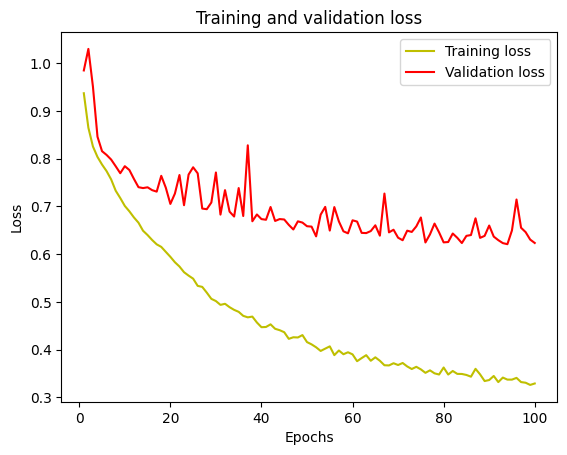

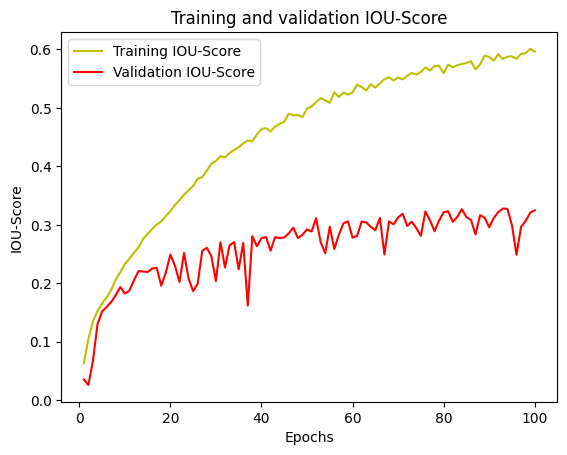

In [54]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU-Score')
plt.plot(epochs, val_acc, 'r', label='Validation IOU-Score')
plt.title('Training and validation IOU-Score')
plt.xlabel('Epochs')
plt.ylabel('IOU-Score')
plt.legend()
plt.show()

In [10]:
model.save(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()})-({SIZE_X}x{SIZE_Y}).hdf5')

In [8]:
model.load_weights(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()}).hdf5')

In [ ]:
test_images, test_masks = load_images(parent_directory, split='test')
test_images_seperate = test_images

test_images, test_masks = preprocess_data(test_images, test_masks)

In [24]:
data_to_save = {
    'test_images': test_images,
    'test_masks': test_masks,
    'test_images_seperate': test_images_seperate
}

pickle_file_path = '..../dataset/test_data.pickle'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)

print(f'Data saved to {pickle_file_path}')

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Data saved to ../dataset/test_data.pickle
Shapes of loaded data:
Test Images: (448, 128, 128, 3)
Test Masks: (448, 128, 128, 10)


In [55]:
pickle_file_path = '../../../dataset/test_data.pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

test_images = loaded_data['test_images']
test_masks = loaded_data['test_masks']
test_images_seperate = loaded_data['test_images_seperate']

test_images, test_masks = preprocess_data(test_images, test_masks)

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Shapes of loaded data:
Test Images: (448, 128, 128, 3)
Test Masks: (448, 128, 128, 10)


In [56]:
_, acc = model.evaluate(test_images, test_masks, verbose=0)
print("Accuracy is = ", (acc * 100.0), "%")

Accuracy is =  37.42790222167969 %


In [57]:
from keras.metrics import MeanIoU
import numpy as np

y_pred = model.predict(test_images)
predicted_masks = np.argmax(y_pred, axis=-1)
test_masks_ = np.argmax(test_masks, axis=-1)

print(predicted_masks.shape)
print(test_masks_.shape)

14/14 [==============================] - 3s 153ms/step
(448, 128, 128)
(448, 128, 128)


In [58]:
class_names = ["Background", "Building Flooded", "Building Non-Flooded", "Road Flooded", "Road Non-Flooded",
               "Water", "Tree", "Vehicle", "Pool", "Grass"]

n_classes = len(class_names)  
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(test_masks_, predicted_masks)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights())
values = values.reshape(n_classes, n_classes)

class_IoUs = []
print("IoU for each class:")
for i in range(n_classes):
    if i == 0: 
        continue
    class_IoU = values[i, i] / (np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i])
    class_IoUs.append(class_IoU)
    print(f"{class_names[i]}: {class_IoU}")

mean_IoU_without_background = np.mean(class_IoUs)
print("Mean IoU (excluding Background):", mean_IoU_without_background)

Mean IoU = 0.5216276
IoU for each class:
Building Flooded: 0.6016571521759033
Building Non-Flooded: 0.618789792060852
Road Flooded: 0.4477539360523224
Road Non-Flooded: 0.7030544877052307
Water: 0.6544091105461121
Tree: 0.6406502723693848
Vehicle: 0.20538011193275452
Pool: 0.30668818950653076
Grass: 0.7792553305625916
Mean IoU (excluding Background): 0.5508487


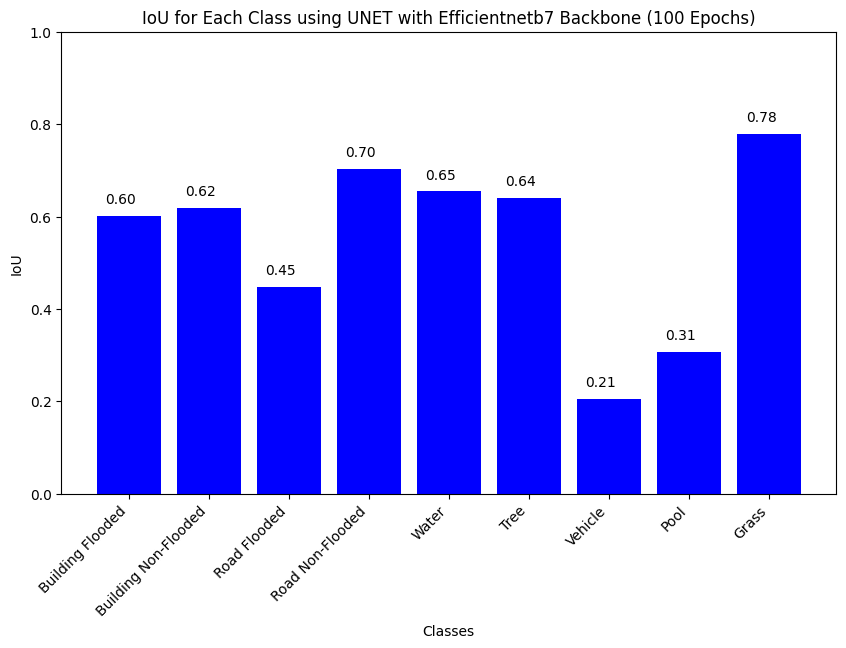

In [59]:
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names[1:], class_IoUs, color='blue')
plt.title(f'IoU for Each Class using {MODEL.upper()} with {BACKBONE.capitalize()} Backbone ({EPOCHS} Epochs)')
plt.xlabel('Classes')
plt.ylabel('IoU')
plt.ylim(0, 1) 
plt.xticks(rotation=45, ha='right')  

for bar, value in zip(bars, class_IoUs):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [60]:
def display_random_function():
    image_id = np.random.randint(0, len(test_images))
    image = test_images_seperate[image_id]
    ground_truth_mask = test_masks_[image_id]
    predicted_mask = predicted_masks[image_id]

    print(f'Image Shape: {image.shape}')
    print(f'Ground Truth Mask Shape: {ground_truth_mask.shape}')
    print(f'Predicted Mask Shape: {predicted_mask.shape}')

    display_images_with_masks(image, ground_truth_mask, predicted_mask)

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


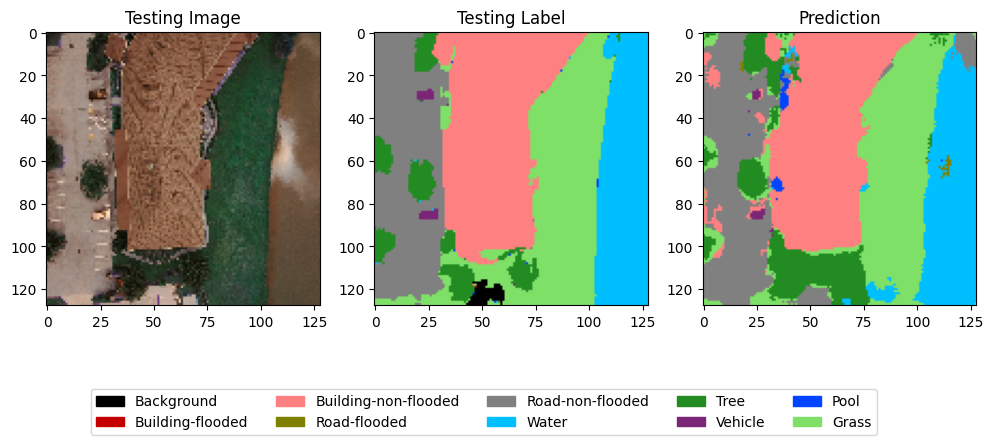

In [61]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


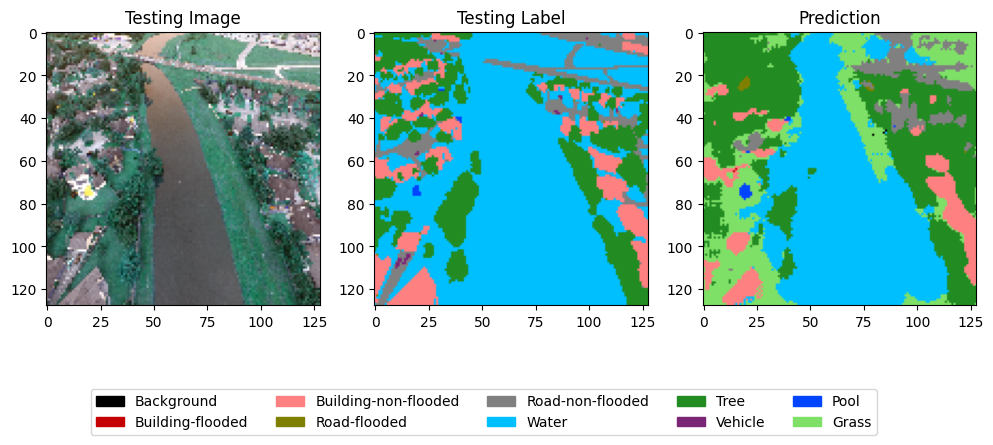

In [62]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


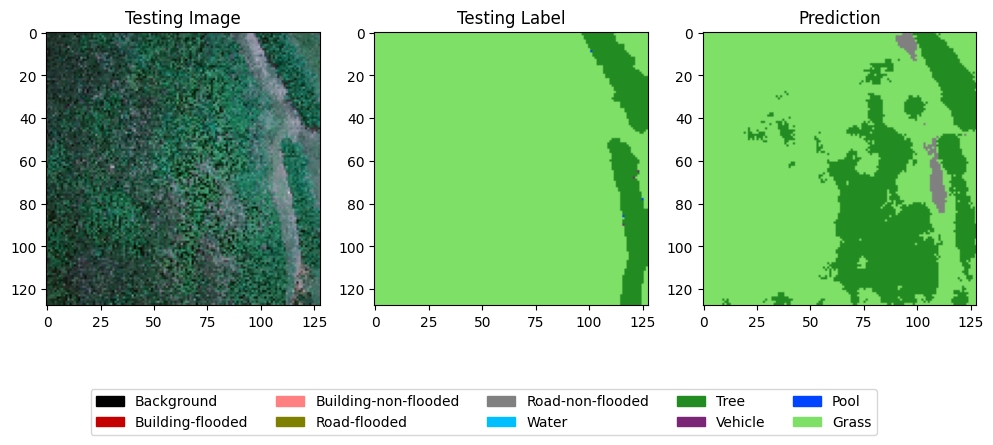

In [63]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


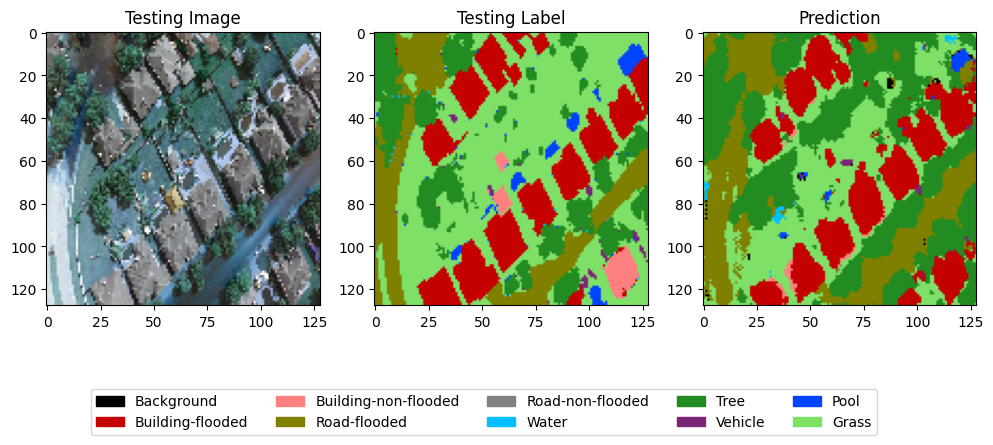

In [64]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


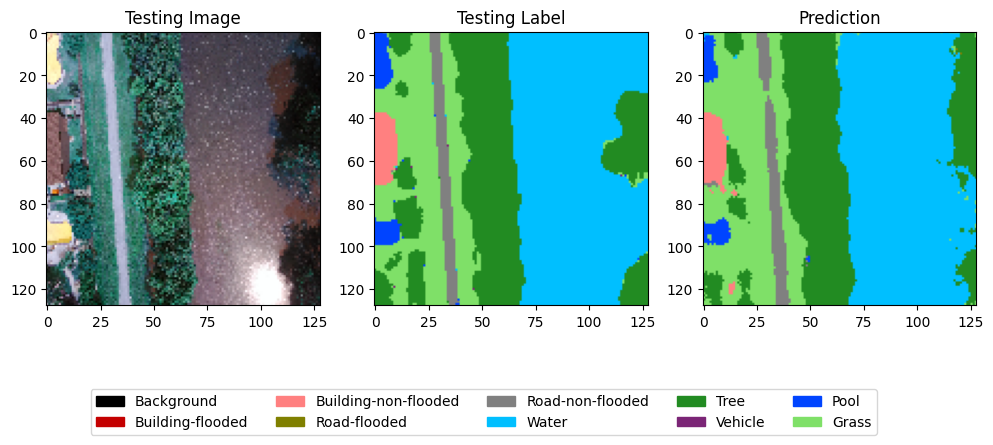

In [65]:
display_random_function()